In [ ]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
from scipy.stats import norm, bernoulli
import json
import warnings; warnings.simplefilter('ignore')
from tqdm.auto import tqdm
from training import train_tree, train_tree_2
from utils import logistic, logistic_cov, active_logistic_pointestimate, inv_hessian_col_imputed, opt_logistic_tuning, make_ess_coverage_plot_intro
from utils_optimization import MinMaxOptimizer_l2, constraint_cross_validation_politeness

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
data = pd.read_csv('data/politeness_dataset.csv')
data = data.sample(frac=1).reset_index(drop=True) # shuffle data
Yhat_string = data["label_gpt4o"].to_numpy()
confidence = data["confidence_in_prediction_gpt-4o"].to_numpy()
device = 'hedge' # 'hedge' or '1pp'
nan_indices = list(np.where(pd.isna(confidence))[0]) + list(np.where(pd.isna(Yhat_string))[0])
good_indices = list(set(range(len(data))) - set(nan_indices))
confidence = confidence[good_indices]
Yhat_string = Yhat_string[good_indices]
Y = data["Politeness"].to_numpy()[good_indices]
n = len(Y)
dict = {"A" : 1, "B" : 0}
Yhat = np.array([dict[Yhat_string[i]] for i in range(n)])
if device == 'hedge':
    X_device = data.to_numpy()[:,[4]][good_indices]
elif device == '1pp':
    X_device = data.to_numpy()[:,[11]][good_indices]
X = np.column_stack((X_device, np.ones(n))).astype(float)
confidence = confidence.reshape(len(confidence),1)

In [ ]:
bi = 600  # we collect the first bi points to initialize sampling rule
n_rem = n - bi
h = inv_hessian_col_imputed(X, Yhat)
tree = train_tree_2(confidence[:bi], np.abs((Y - Yhat)[:bi]) ** 2)
error = np.sqrt(tree.predict(confidence)) * np.abs(X.dot(h))
uncertainties = (1 - 2 * np.abs(confidence - 0.5)).reshape(-1) * np.abs(X.dot(h))

In [ ]:
from utils import opt_logistic_tuning
alpha = 0.1  # desired error level for confidence interval

num_trials = 500
budgets = np.linspace(0.32, 0.7, 10)  # overall sampling bg
true_pointest = logistic(X,Y)
true_effect = true_pointest[0]  
true_Sigma = logistic_cov(true_pointest, X, Y, Yhat, np.ones(n), lam=0)

num_methods = 3
temp_df = pd.DataFrame({
    "lb": np.zeros(num_methods),
    "ub": np.zeros(num_methods),
    "interval width": np.zeros(num_methods),
    "coverage": np.zeros(num_methods),
    "estimator": [""] * num_methods,
    "$n_b$": np.zeros(num_methods),
})

cv_list = [0.01, 0.05, 0.1, 0.5, 1, 5, 10]
k = 5 
c_list = constraint_cross_validation_politeness(confidence[:bi], X[:bi], Y[:bi], Yhat[:bi], cv_list, k, budgets, h, device)

tau_list = []
n_rem = n - bi
for i in range(len(budgets)):
    constraint_sum = c_list[i] * np.sqrt(n_rem)
    bg = budgets[i]
    eta = bg / np.mean(uncertainties)
    pi = np.clip(eta*uncertainties, 0.0, 1.0)
    nb = bg * n_rem
    optimizer = MinMaxOptimizer_l2(error[bi:], pi[bi:], nb, n_rem, constraint_sum)
    optimal_value, optimal_r= optimizer.optimize()
    tau_list.append(optimal_r)


results = []

for j in range(len(budgets)):
    bg = budgets[j]
    
    for i in range(num_trials):
        
        avg_uncertainty = np.mean(uncertainties)
        weights_active = np.zeros(n)
        weights = np.zeros(n)
        weights_active[:bi] = 1
        weights[:bi] = 1

        sampling_prob = uncertainties[bi:]/avg_uncertainty*bg
        tau = 0.01
        prob_1 = np.clip((1-tau)*sampling_prob + tau*bg, 0, 1)    
        tau = tau_list[j]
        prob_2 = np.clip(sampling_prob ** (1-tau) * bg ** tau / np.sum(sampling_prob ** (1-tau) * bg ** tau) * (bg) * (n - bi), 0.0, 1.0)

        weights_active[bi:] = bernoulli.rvs(prob_2)/np.clip(prob_2, 0.0, 1.0)
        weights_active[bi:] = bernoulli.rvs(prob_1)/prob_1



        xi_unif = bernoulli.rvs([bg] * n_rem)
        weights[bi:] = xi_unif/bg
        pointest = active_logistic_pointestimate(X, Y, Yhat, weights, lam=1)
        Sigmahat = logistic_cov(pointest, X, Y, Yhat, weights, lam=1)
        l = pointest - norm.ppf(1-alpha/2)*np.sqrt(np.diag(Sigmahat)/n)
        u = pointest + norm.ppf(1-alpha/2)*np.sqrt(np.diag(Sigmahat)/n)
        coverage = (true_effect >= l[0])*(true_effect <= u[0])
        temp_df.loc[0] = l[0], u[0], u[0]-l[0], coverage, "uniform", int((n - bi)*bg + bi)

        pointest_init = active_logistic_pointestimate(X, Y, Yhat, weights_active, lam=1)
        lam = opt_logistic_tuning(pointest_init, X, Y, Yhat, weights_active)


        pointest = active_logistic_pointestimate(X, Y, Yhat, weights_active, lam=lam)
        Sigmahat = logistic_cov(pointest, X, Y, Yhat, weights_active, lam=lam)
        l = pointest - norm.ppf(1-alpha/2)*np.sqrt(np.diag(Sigmahat)/n)
        u = pointest + norm.ppf(1-alpha/2)*np.sqrt(np.diag(Sigmahat)/n)
        coverage = (true_effect >= l[0])*(true_effect <= u[0])
        temp_df.loc[1] = l[0], u[0], u[0]-l[0], coverage, "active", int((n - bi)*bg + bi)

        weights_active[bi:] = bernoulli.rvs(prob_2)/np.clip(prob_2, 0.0, 1.0)

        pointest = active_logistic_pointestimate(X, Y, Yhat, weights_active, lam=lam)
        Sigmahat = logistic_cov(pointest, X, Y, Yhat, weights_active, lam=lam)
        l = pointest - norm.ppf(1-alpha/2)*np.sqrt(np.diag(Sigmahat)/n)
        u = pointest + norm.ppf(1-alpha/2)*np.sqrt(np.diag(Sigmahat)/n)
        coverage = (true_effect >= l[0])*(true_effect <= u[0])
        temp_df.loc[2] = l[0], u[0], u[0]-l[0], coverage, "robust active", int((n - bi)*bg + bi)

        results += [temp_df.copy()]
df = pd.concat(results,ignore_index=True)
df["coverage"] = df["coverage"].astype(bool)

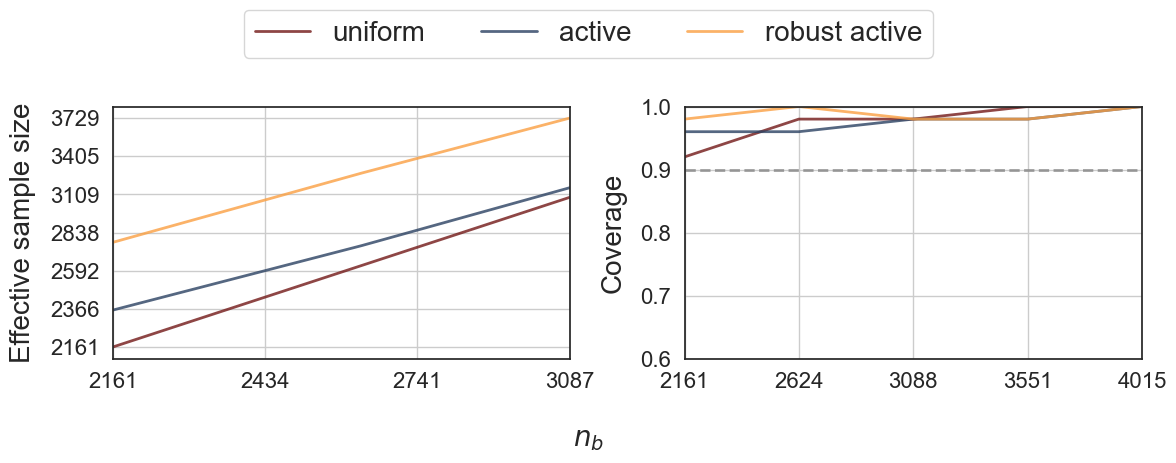

In [ ]:
make_ess_coverage_plot_intro(df, "logistic regression coefficient β$_{\mathrm{" + 'hedge' + "}}$", "llm_politeness_ess_coverage.pdf", true_effect)
